<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Carregamento dos dados

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

dataset = pd.read_csv("dados_ies_novas_categorias_utf8.csv", index_col=0, encoding="latin-1")

#dataset.drop(dataset[dataset.TIPO_CATEGORIA_ADM == "Especial"].index, inplace=True)
#dataset.drop(dataset[dataset.TIPO_CATEGORIA_ADM == "Pública Municipal"].index, inplace=True)
set(dataset["TIPO_CATEGORIA_ADM"])
#dataset.dropna(subset=["TIPO_CATEGORIA_ADM"], inplace=True)
#print(set(dataset["TIPO_CATEGORIA_ADM"]))
#dataset.to_csv("dados_ies_sem_nan_sem_privadas_especial_utf8.csv")

#dataset.shape

{'Nacional', 'Sub-Nacional'}

# Categorização e mapeamento dos dados de strings para inteiros

In [3]:
from sklearn import preprocessing
from copy import deepcopy

u = deepcopy(dataset)

le = preprocessing.LabelEncoder()

le.fit(dataset["TIPO_CATEGORIA_ADM"])
dataset["TIPO_CATEGORIA_ADM"]=le.transform(dataset["TIPO_CATEGORIA_ADM"])
le_name_mapping_1 = dict(zip(le.classes_, le.transform(le.classes_)))

le.fit(dataset["REGIAO"])
dataset["REGIAO"]=le.transform(dataset["REGIAO"])
le_name_mapping_2 = dict(zip(le.classes_, le.transform(le.classes_)))

le.fit(dataset["UF"])
dataset["UF"]=le.transform(dataset["UF"])
le_name_mapping_3 = dict(zip(le.classes_, le.transform(le.classes_)))

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import json
a = json.dumps(le_name_mapping_1, default=np_encoder, indent=True, ensure_ascii=False)
b = json.dumps(le_name_mapping_2, default=np_encoder, indent=True, ensure_ascii=False)
c = json.dumps(le_name_mapping_3, default=np_encoder, indent=True, ensure_ascii=False)

ff = '{'
ff += f'\n"TIPO_CATEGORIA_ADM": [\n{a}\n],\n"REGIAO": [\n{b}\n],\n"UF": [\n{c}\n]'
ff += '\n}'

f = open("mapa_categorias.json", "w")
f.write(ff)
f.close()

dataset.to_csv("dados_ies_categorizados.csv")

dataset

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,0,0,10,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,0,0,6,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,0,1,24,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
3,107,4,0,2,3,64.0,33.0,54.0,60.0,2.0,0.000000,0.000000,0.719626,0.000000,0.000000
4,100,5,0,1,17,137.0,50.0,73.0,36.0,3.0,4.200000,5.880000,5.880000,2.520000,2.520000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,2,23700,1,3,25,0.0,0.0,1.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.000000
2602,2,23705,1,3,25,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2603,1,23713,1,3,20,1.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2605,1,23867,1,3,25,1.0,0.0,0.0,0.0,0.0,2.000000,2.000000,2.000000,1.000000,1.000000



# Predição do dataset utilizando KNN

Processa células não padronizadas (células vazias)

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in dataset.columns:
  if dataset[i].dtype == object:
    dataset[i] = le.fit_transform(dataset[i])
  else:
    pass

dataset_encoded = le.fit_transform(dataset.columns)

Normaliza os dados usando StandardScaler e treina o modelo

In [5]:
X = dataset.drop(columns=[ 
                          "TIPO_CATEGORIA_ADM",
                          "DEFICIENCIA_AUDITIVA",
                          "DEFICIENCIA_MULTIPLA",
                          "RECURSOS_DEF_VISUAL",
                          "RECURSOS_DEF_COGNITIVA",
                          "RECURSOS_DEF_AUDITIVA",
                          "RECURSOS_DEF_MULTIPLA",
                          "REGIAO",
                          "UF"
                          ])
y = dataset["TIPO_CATEGORIA_ADM"].values

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

Cria o objeto KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [7]:
y_pred

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1])

Faz a predição

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Confusion matrix:

[[27 15]
 [12 40]]

Classification report:

              precision    recall  f1-score   support

           0       0.69      0.64      0.67        42
           1       0.73      0.77      0.75        52

    accuracy                           0.71        94
   macro avg       0.71      0.71      0.71        94
weighted avg       0.71      0.71      0.71        94

Accuracy:  0.7127659574468085


In [9]:
knn = KNeighborsClassifier(n_neighbors=1, metric="euclidean")
k = knn.fit(X_train, y_train)
pred_i = knn.predict(X_test)
k_score = k.score(X_test, y_test)
k_score

0.7659574468085106

Text(0, 0.5, 'Erro médio')

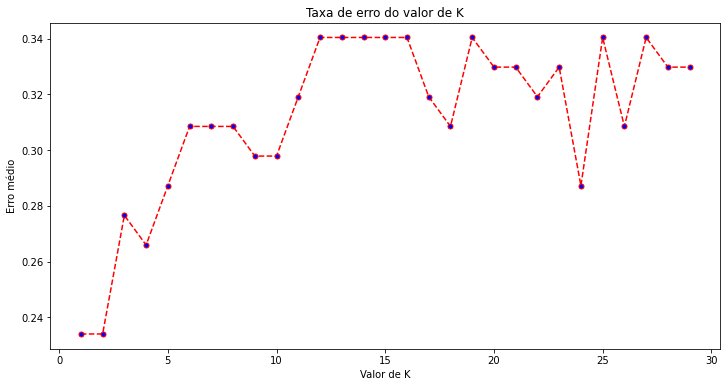

In [10]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5)
plt.title('Taxa de erro do valor de K')
plt.xlabel('Valor de K')
plt.ylabel('Erro médio')

In [11]:
X_train

,NUM_CURSOS,CODIGO_IES,DEFICIENCIA_FISICA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,RECURSOS_DEF_FISICA
272,150,569,223.0,81.0,67.0,2.453333
461,4,967,1.0,0.0,1.0,2.250000
2217,9,18165,78.0,92.0,20.0,2.777778
1353,61,3164,3.0,1.0,0.0,0.000000
1549,37,3984,40.0,19.0,6.0,0.405405
...,...,...,...,...,...,...
473,57,1028,10.0,7.0,3.0,0.000000
1567,4,4023,0.0,2.0,0.0,1.500000
299,52,596,13.0,4.0,1.0,1.057692
1635,43,4358,15.0,11.0,14.0,1.744186


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


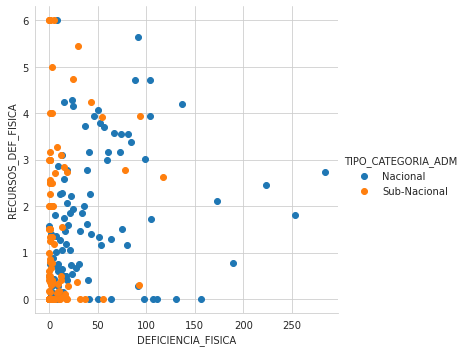

In [12]:
sns.set_style("whitegrid");
sns.FacetGrid(dataset, hue="TIPO_CATEGORIA_ADM", size=5).map(plt.scatter, "DEFICIENCIA_FISICA", "RECURSOS_DEF_FISICA").add_legend();
plt.show()

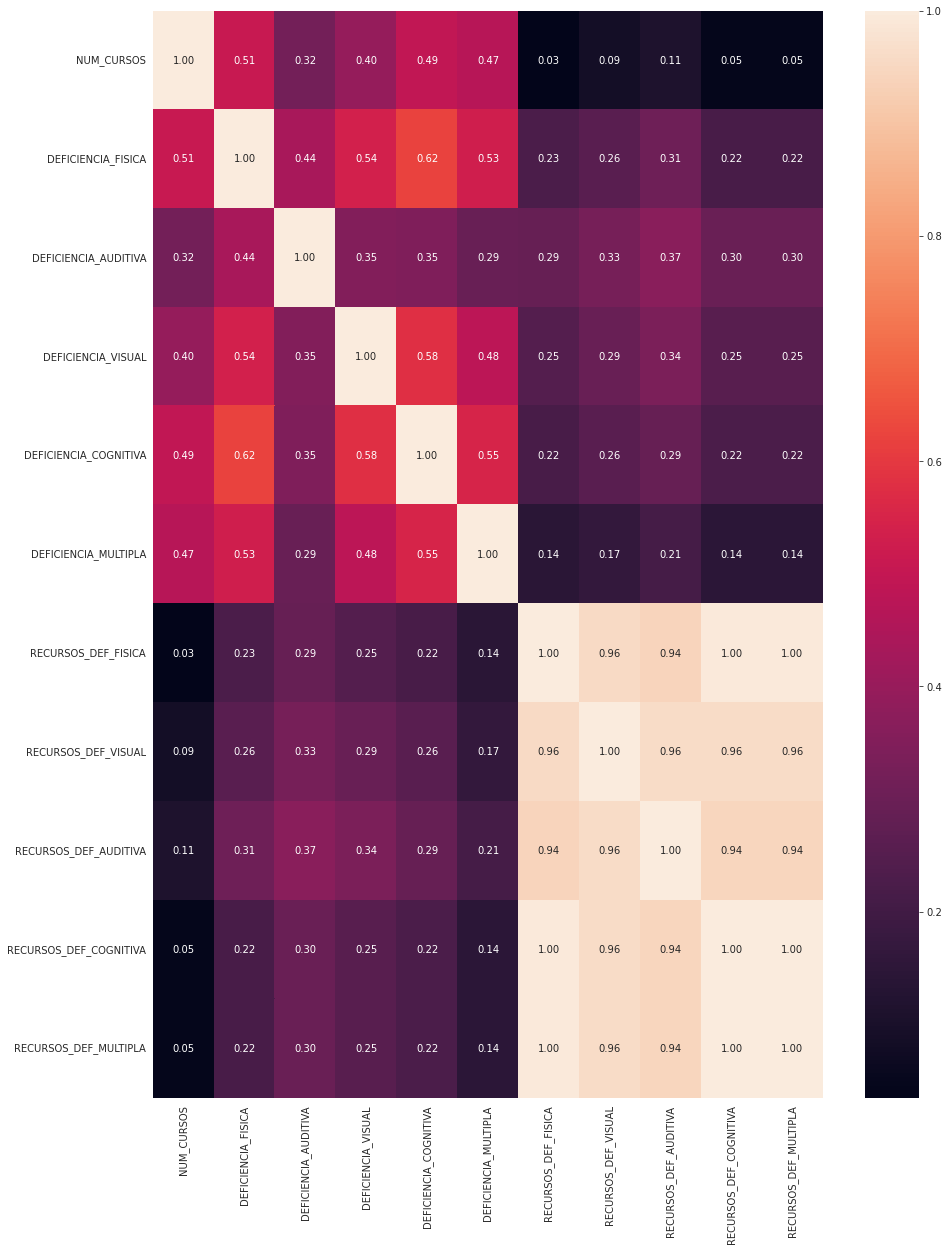

In [13]:
from pylab import rcParams

def plot_correlation(data):
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

df = dataset.drop(columns=[
                          "REGIAO", 
                          "TIPO_CATEGORIA_ADM", 
                          "UF", 
                          "CODIGO_IES"
                          ])

plot_correlation(df)

In [ ]:
X = X_train.to_numpy()
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
#Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [25]:
X = X_train.to_numpy()
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue="TIPO_CATEGORIA_ADM",
    palette=["darkorange", "c", "darkblue"],
    alpha=1.0,
    edgecolor="black"
)

array([[2.96000000e+02, 5.50000000e+01, 3.00000000e+00, ...,
        1.00000000e+01, 2.30000000e+01, 4.89864865e-01],
       [2.00000000e+00, 2.34380000e+04, 3.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [7.60000000e+01, 7.00000000e+00, 3.00000000e+00, ...,
        5.00000000e+00, 0.00000000e+00, 1.57894737e+00],
       ...,
       [7.00000000e+00, 7.90000000e+01, 3.00000000e+00, ...,
        3.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50000000e+01, 3.20000000e+01, 1.00000000e+00, ...,
        3.00000000e+00, 2.00000000e+00, 0.00000000e+00],
       [9.60000000e+01, 6.34000000e+02, 4.00000000e+00, ...,
        4.50000000e+01, 3.50000000e+01, 1.33333333e+00]])

ValueError: ignored

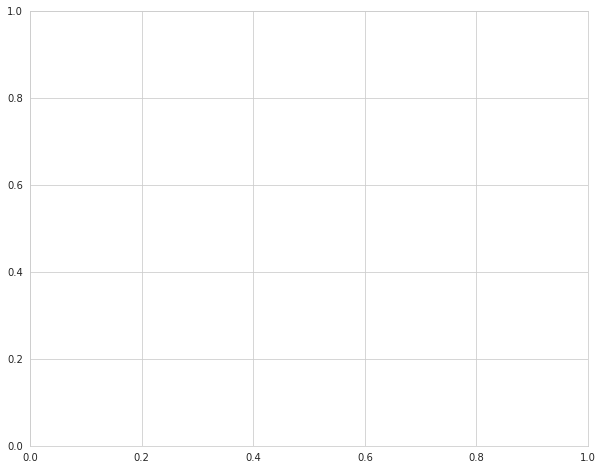

In [20]:

def knn_comparison(X, y, k):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X, y)
  value=1.5
  width=0.75
# Plotting decision region
  plt.figure(figsize=(10, 8))
  plot_decision_regions(
     X.to_numpy(), 
     y, 
     clf=clf,
     legend=2, 
     feature_index=[1,5], 
     filler_feature_values={0: value, 3: value, 4: value, 5: value, 2: value, },  
     filler_feature_ranges={0: width, 3: width, 4: width, 5: width, 2: width}
     )
# Adding axes annotations
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Knn com K=" + str(k))
  plt.show()

for i in [6]:
  knn_comparison(X_train, y_train, i)

Accuracy: 0.3617021276595745
Precision: 0.3696969696969697
Recall: 0.3617021276595745


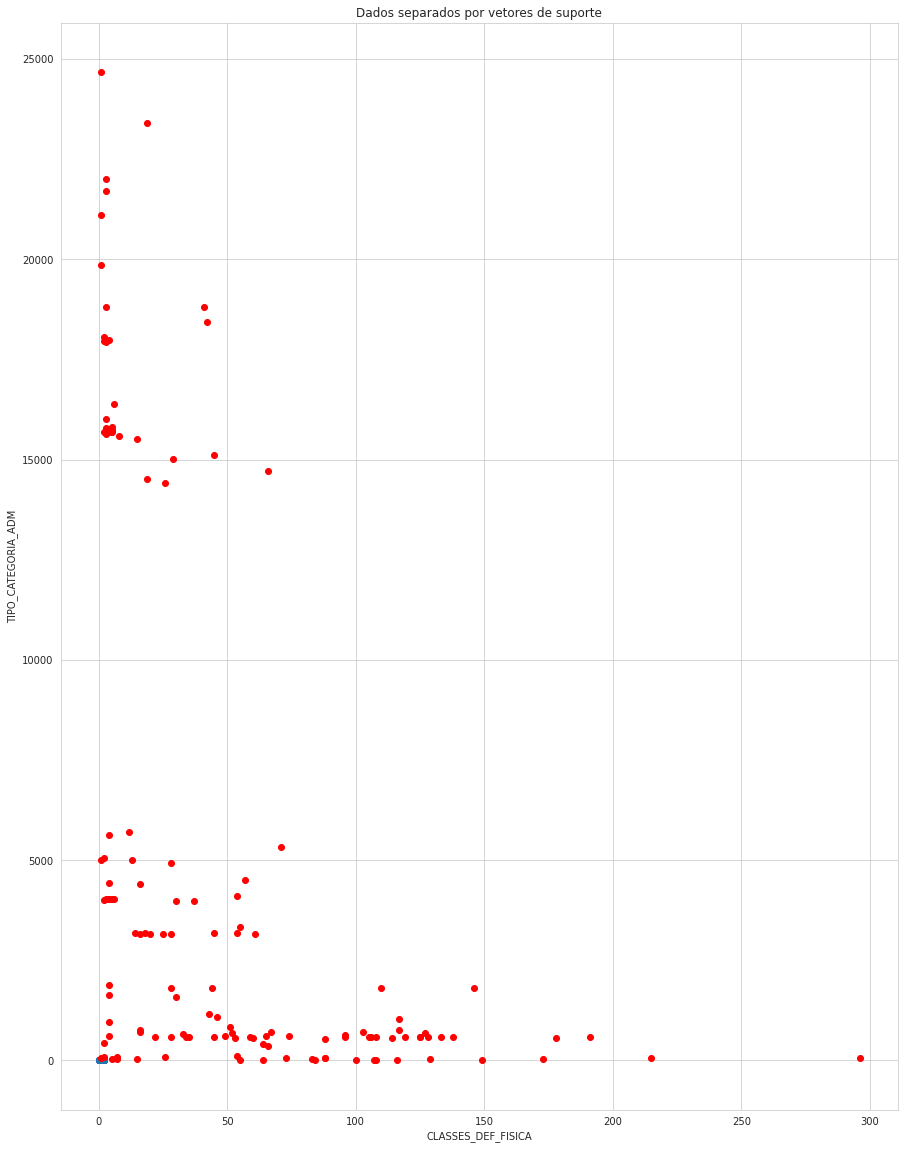

In [ ]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="weighted"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="weighted"))

support_vector_indices = clf.support_
#print(support_vector_indices)

support_vector_classes = clf.n_support_
#print(support_vector_classes)

support_vectors = clf.support_vectors_
plt.scatter(X_train["CLASSES_DEF_VISUAL"], X_train["TIPO_CATEGORIA_ADM"])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color="red")
plt.title("Dados separados por vetores de suporte")
plt.xlabel("CLASSES_DEF_FISICA")
plt.ylabel("TIPO_CATEGORIA_ADM")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

p_grid = [
          {'C': [0.5, 1, 10, 100],
           'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
           'kernel': ['rbf']},
]

optimal = GridSearchCV(
    svm.SVC(),
    p_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal.fit(X_train, y_train)
print(optimal.best_params_)

{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}


Accuracy: 0.3191489361702128
Precision: 0.10185604345857854
Recall: 0.3191489361702128


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


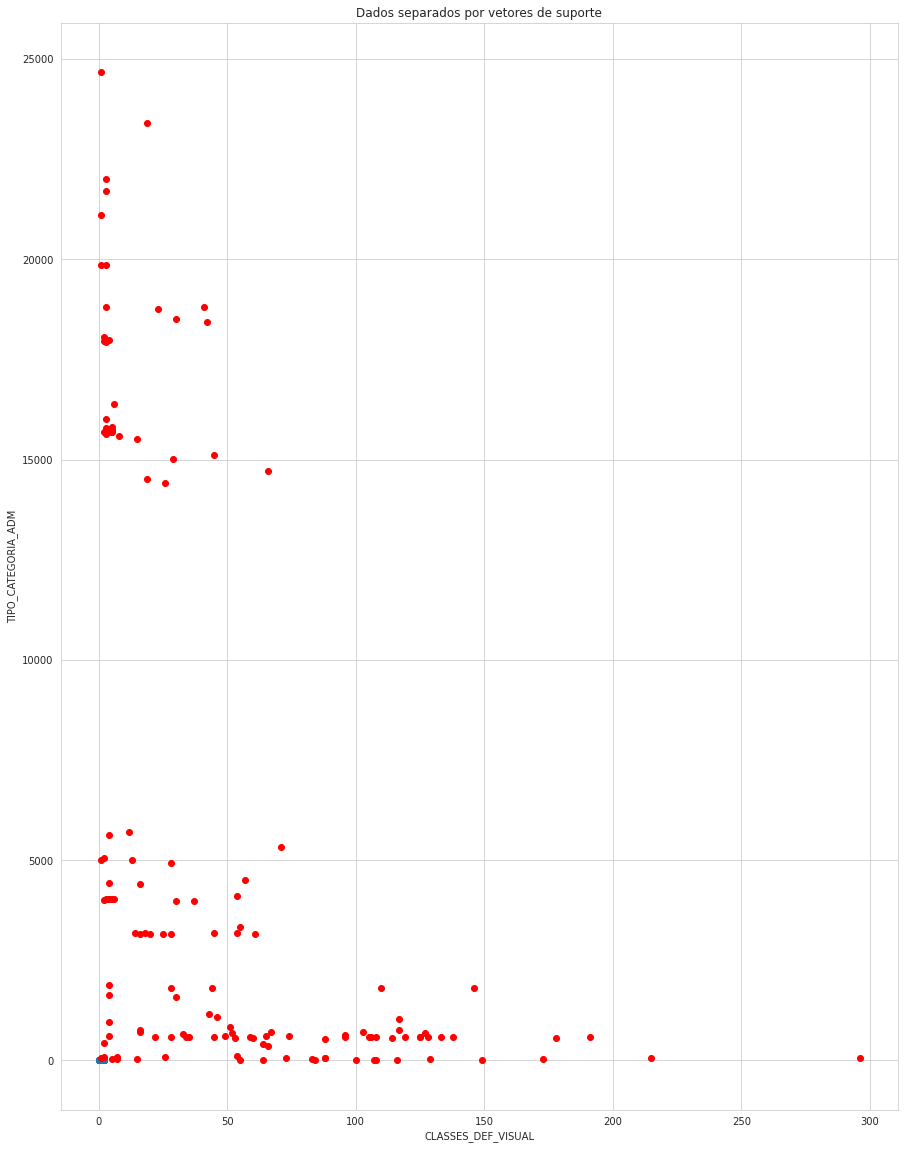

In [ ]:
clf = svm.SVC(kernel='rbf', C=0.5, gamma=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="weighted"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="weighted"))

support_vector_indices = clf.support_
#print(support_vector_indices)

support_vector_classes = clf.n_support_
#print(support_vector_classes)

support_vectors = clf.support_vectors_
plt.scatter(X_train["CLASSES_DEF_VISUAL"], X_train["TIPO_CATEGORIA_ADM"])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color="red")
plt.title("Dados separados por vetores de suporte")
plt.xlabel("CLASSES_DEF_VISUAL")
plt.ylabel("TIPO_CATEGORIA_ADM")
plt.show()